## Exploratory data analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
commit_metrics_df = pd.read_csv("data/commit_metrics_bleed-baidu-white.csv")

commit_metrics_df['date'] = pd.to_datetime(commit_metrics_df['date'], utc=True)

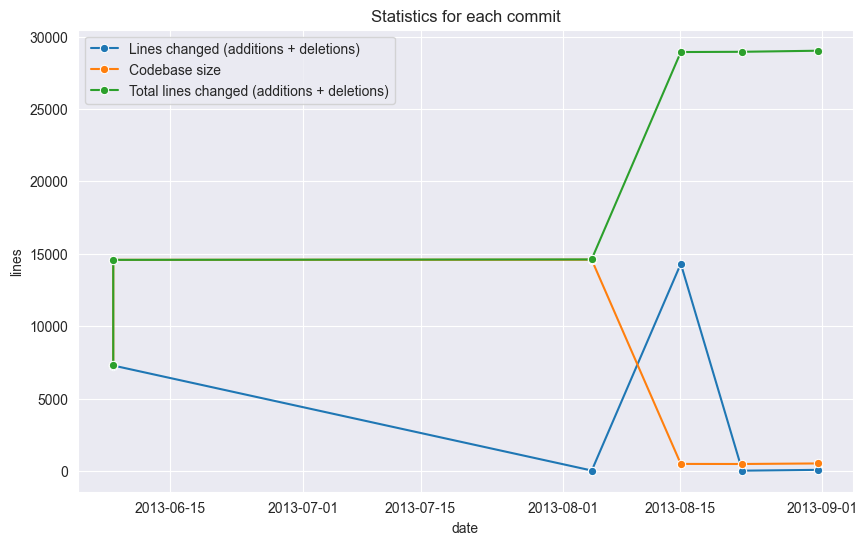

In [3]:
plt.figure(figsize=(10, 6))
commit_metrics_until_stagnant = commit_metrics_df[commit_metrics_df['date'] < pd.Timestamp(2017, 1, 1, 12).tz_localize('Europe/Stockholm')]
sns.lineplot(data=commit_metrics_until_stagnant, x='date', y='lines', marker='o', label='Lines changed (additions + deletions)')
sns.lineplot(data=commit_metrics_until_stagnant, x='date', y='codebase_size', marker='o', label='Codebase size')
sns.lineplot(data=commit_metrics_until_stagnant, x='date', y='all_lines', marker='o', label='Total lines changed (additions + deletions)')
plt.legend()
plt.title("Statistics for each commit");